# d-HSIC Independence test amongst SDGs

Joint Independence test

$H_0: \mathbb{P}_{\mathbf{X}} = \mathbb{P}_{X_1} \mathbb{P}_{X_2} \dots \mathbb{P}_{X_d}$

We compute these depedencies on a goal level. We work with the concatenated time-series, where each country corresponds to an independent sample.

In this notebook we work with groupings of countries according to continents.

## Implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group
import pickle
from sklearn.metrics import pairwise_distances, pairwise_kernels
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import RBF
import networkx as nx
from tqdm.notebook import tqdm

import os
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning) 

import pandas as pd

import copy

## Loading standardised imputed data set
We load first of all the standardised imputed data set which we have generated with the previous notebook.

In [2]:
targets_values_i = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/targets_values_i_up_arr_wb.pkl', 'rb'))
goals_values_i = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/goals_values_i_up_arr_wb.pkl', 'rb'))

In [3]:
# read amended csv file
c = pd.read_csv('/Users/saravallejomengod/MathsYear4/M4R/utils/countries_wb.csv', dtype=str, delimiter=';', header=None)
countries = list(c[0])
continents = pd.read_csv(r'/Users/saravallejomengod/MathsYear4/M4R/utils/continents.csv')
continents.replace({"Democratic People's Republic of Korea": "Korea, Dem. People's Rep.", 'Gambia': 'Gambia, The', 'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom', 'Congo': 'Congo, Rep.', 'Democratic Republic of the Congo': 'Congo, Dem. Rep.', 'Czechia': 'Czech Republic', 'Iran (Islamic Republic of)': 'Iran, Islamic Rep.', "Côte d'Ivoire": "Cote d'Ivoire", 'Kyrgyzstan': 'Kyrgyz Republic', "Lao People's Democratic Republic": 'Lao PDR', 'Republic of Moldova': 'Moldova', 'Micronesia (Federated States of)': 'Micronesia, Fed. Sts.', 'Slovakia': 'Slovak Republic', 'Viet Nam': 'Vietnam', 'Egypt': 'Egypt, Arab Rep.', 'United Republic of Tanzania': 'Tanzania','United States of America': 'United States', 'Venezuela (Bolivarian Republic of)': 'Venezuela, RB', 'Yemen': 'Yemen, Rep.', 'Bahamas': 'Bahamas, The', 'Bolivia (Plurinational State of)': 'Bolivia'}, inplace=True)
info = pd.read_csv(r'/Users/saravallejomengod/MathsYear4/M4R/utils/wb_info.csv', header=None)

In [4]:
# removes key in-place
countries.remove('Micronesia, Fed. Sts.')
continents['Oceania (excl. AUS + NZ)'] = continents['Oceania (excl. AUS + NZ)'].drop(index=4) # removing Micronesia
continents['Oceania (incl. AUS + NZ)'] = continents['Oceania (incl. AUS + NZ)'].drop(index=6) # removing Micronesia
continents['World'] = continents['World'].drop(index=170) # removing Micronesia
continents.drop(['Northern Africa', 'Southern Africa', 'North America', 'Australia and New Zealand'], axis=1, inplace=True)


In [5]:
continents

,Eastern Africa,Middle Africa,Western Africa,Sub-Saharan Africa,Africa,Caribbean,Central America,South America,Latin America and the Caribbean,Americas,...,Western Asia,Asia,Eastern Europe,Northern Europe,Southern Europe,Western Europe,Europe,Oceania (excl. AUS + NZ),Oceania (incl. AUS + NZ),World
0,Burundi,Angola,Benin,Burundi,Algeria,Antigua and Barbuda,Belize,Argentina,Antigua and Barbuda,Antigua and Barbuda,...,Armenia,Kazakhstan,Belarus,Denmark,Albania,Austria,Belarus,Fiji,Australia,Algeria
1,Comoros,Cameroon,Burkina Faso,Comoros,"Egypt, Arab Rep.","Bahamas, The",Costa Rica,Bolivia,"Bahamas, The","Bahamas, The",...,Azerbaijan,Kyrgyz Republic,Bulgaria,Estonia,Bosnia and Herzegovina,Belgium,Bulgaria,Papua New Guinea,New Zealand,"Egypt, Arab Rep."
2,Djibouti,Central African Republic,Cote d'Ivoire,Djibouti,Morocco,Barbados,El Salvador,Brazil,Barbados,Barbados,...,Bahrain,Tajikistan,Czech Republic,Finland,Croatia,France,Czech Republic,Solomon Islands,Fiji,Morocco
3,Eritrea,Chad,"Gambia, The",Eritrea,Tunisia,Cuba,Guatemala,Chile,Cuba,Cuba,...,Cyprus,Turkmenistan,Hungary,Iceland,Greece,Germany,Hungary,Vanuatu,Papua New Guinea,Tunisia
4,Ethiopia,"Congo, Rep.",Ghana,Ethiopia,Burundi,Dominica,Honduras,Colombia,Dominica,Dominica,...,Georgia,Uzbekistan,Poland,Ireland,Italy,Luxembourg,Poland,NaN,Solomon Islands,Burundi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Palau
172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kiribati
173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Samoa
174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tonga


We generate a list for all unique targets with their corresponding indicators. 

In [6]:
targets = list(info[4].unique())
targets.remove('T')
dict_targets = {}

for target in targets:
    t = info[0].where(info[4] == target)

    dict_targets[target] = [i for i in t if str(i) != 'nan']

In [7]:
#check 
dict_targets['1.2']

['SI.POV.MDIM',
 'SI.POV.MDIM.17',
 'SI.POV.MDIM.17.XQ',
 'SI.POV.MDIM.FE',
 'SI.POV.MDIM.HH',
 'SI.POV.MDIM.IT',
 'SI.POV.MDIM.MA',
 'SI.POV.MDIM.XQ',
 'SI.POV.NAHC',
 'SI.POV.RUHC',
 'SI.POV.URHC']

Similarly, we create a list with all unique SDGs and their corresponding targets.

In [8]:
goals = list(info[3].unique())
goals.remove('T')
dict_goals = {}

for goal in goals:
    g = info[4].where(info[3] == goal)

    dict_goals[goal] = [t for t in g if str(t) != 'nan']
    dict_goals[goal] = list(set(dict_goals[goal]))

In [9]:
#check 
print(dict_goals['1'])

['1.3', '1.2', '1.1']


Since we will work with groupings of countries according to continents, we prepare the data in the following way. We create a dictionary with continents as keys; such that the corresponding value is a 17-vector where each entry corresponds to an SDG. These entries are matrices with each row corresponding to a country.

In [10]:
# data preparation
continents_prep_g = {}

for continent in continents:
    print(continent)
    
    continents_prep_g[continent] = np.empty(17, dtype=object)
    
    for g, goal in enumerate(goals):
        g_list = []
        for country in continents[continent].dropna():
            g_list.append(np.asarray(goals_values_i[country][g]))

        continents_prep_g[continent][g] = np.asarray(g_list)

Eastern Africa
Middle Africa
Western Africa
Sub-Saharan Africa
Africa
Caribbean
Central America
South America
Latin America and the Caribbean
Americas
Central and Eastern Asia
South-eastern Asia
Southern Asia
Western Asia
Asia
Eastern Europe
Northern Europe
Southern Europe
Western Europe
Europe
Oceania (excl. AUS + NZ)
Oceania (incl. AUS + NZ)
World


In [11]:
len(goals)

17

In [12]:
# data preparation
continents_prep_t = {}

for continent in continents:
    print(continent)
    
    continents_prep_t[continent] = np.empty(76, dtype=object)
    
    for t, target in enumerate(targets):
        t_list = []
        for country in continents[continent].dropna():
            t_list.append(np.asarray(targets_values_i[country][t]))

        continents_prep_t[continent][t] = np.asarray(t_list)

Eastern Africa
Middle Africa
Western Africa
Sub-Saharan Africa
Africa
Caribbean
Central America
South America
Latin America and the Caribbean
Americas
Central and Eastern Asia
South-eastern Asia
Southern Asia
Western Asia
Asia
Eastern Europe
Northern Europe
Southern Europe
Western Europe
Europe
Oceania (excl. AUS + NZ)
Oceania (incl. AUS + NZ)
World


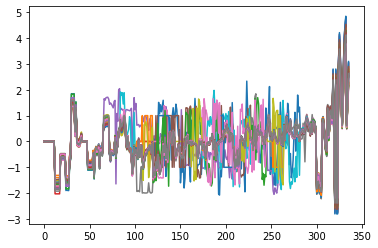

In [13]:
#show some concatenated time series for specific SDG and Continent
plt.plot(continents_prep_t['Europe'][1-1].T)
plt.show()

In [14]:
continents_prep_g['Caribbean'][0].shape

(10, 447)

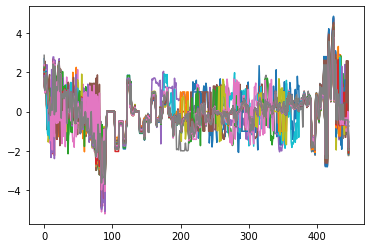

In [15]:
#show some concatenated time series for specific SDG and Continent
plt.plot(continents_prep_g['Europe'][1-1].T)
plt.show()

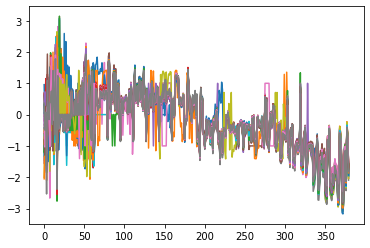

In [16]:
plt.plot(continents_prep_g['Europe'][2-1].T)
plt.show()

## d-HSIC between goals

We compute the d-HSIC on a goal level and perform and independence test.

### Combinations

We need to compute this statistic on all possible d-combinations of the 17 SDGs. Therefore, we create the following functions that given a set and a number r computes all possible combinations without order.

In [17]:
def combinations(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield list(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield list(pool[i] for i in indices)

In [18]:
def combinations_tuple(iterable, r):
    # combinations('ABCD', 2) --> AB AC AD BC BD CD
    # combinations(range(4), 3) --> 012 013 023 123
    pool = tuple(iterable)
    n = len(pool)
    if r > n:
        return
    indices = list(range(r))
    yield tuple(pool[i] for i in indices)
    while True:
        for i in reversed(range(r)):
            if indices[i] != i + n - r:
                break
        else:
            return
        indices[i] += 1
        for j in range(i+1, r):
            indices[j] = indices[j-1] + 1
        yield tuple(pool[i] for i in indices)

## d-HSIC implementation

In [19]:
def width(Z):
    """
    Computes the median heuristic for the kernel bandwidth
    """
    dist_mat = pairwise_distances(Z, metric='euclidean')
    width_Z = np.median(dist_mat[dist_mat > 0])
    return width_Z

In [20]:
def make_K_list(X_list, n_samples, n_nodes):
    """
    Computes the kernel matrices of the variables in X_array, where each column represents one variable.
    Returns a list of the kernel matrices of each variable.
    """
    k_list = list(pairwise_kernels(X_list[i], metric='rbf', gamma=0.5/(width(X_list[i])**2)) for i in range(n_nodes))
    return k_list

In [21]:
def dHSIC(k_list):
    """
    Computes the dHSIC statistic
    """
    n_nodes = len(k_list)
    n_samples = k_list[0].shape[0]
    
    term1, term2, term3 = 1, 1, 2/n_samples    
    for j in range(n_nodes):
        term1 = term1 * k_list[j]
        term2 = term2 * np.sum(k_list[j]) / (n_samples**2)
        term3 = term3 * np.sum(k_list[j], axis=0) / n_samples
    term1_sum = np.sum(term1)
    term3_sum = np.sum(term3)
    dHSIC = term1_sum/(n_samples**2) + term2 - term3_sum
    return dHSIC

In [22]:
def dHSIC_permutation_MC(k_list, n_samples, n_nodes, stat_found, n_perms=5000, alpha=0.05):
    """
    Approximates the null distribution by permutating all variables. Using Monte Carlo approximation.
    """
    # initiating statistics
    statistics = np.zeros(n_perms)
    
    for i in range(n_perms):
        term1 = k_list[0]
        term2 = np.sum(k_list[0])/(n_samples**2)
        term3 = 2 * np.sum(k_list[0], axis=0) / (n_samples**2)

        for j in range(1, n_nodes):
            index_perm = np.random.permutation(k_list[j].shape[0])
            k_perm = k_list[j][index_perm, index_perm[:, None]]

            term1 = term1 * k_perm
            term2 = term2 * np.sum(k_perm) / (n_samples**2)
            term3 = term3 * np.sum(k_perm, axis=0) / n_samples

        term1_sum = np.sum(term1)
        term3_sum = np.sum(term3)

        statistics[i] = term1_sum/(n_samples**2) + term2 - term3_sum
    
    statistics_sort = np.sort(statistics)
    # computing 1-alpha critical value
    Bind = np.sum(stat_found==statistics_sort) + int(np.ceil((1-alpha)*(n_perms+1)))
    critical_value = statistics_sort[Bind]
    
    return critical_value

In [26]:
def joint_independence_test_MC(X_list, n_perms=5000, alpha=0.05):
    """
    Performs the independence test with HSIC and returns an accept or reject statement
    
    Inputs:
    X_list: list of variables, each having dimensions (n_samples, n_obs)  
    n_perms: number of permutations performed when bootstrapping the null
    alpha: rejection threshold of the test
    make_K: function called to construct the kernel matrix 
    
    Returns:
    reject: 1 if null rejected, 0 if null accepted
    
    """
    
    n_nodes = len(X_list)
    n_samples, n_obs = X_list[0].shape
    
    # compute list of kernel matrices
    K_list = make_K_list(X_list, n_samples, n_nodes)
    
    # statistic and threshold
    stat = dHSIC(K_list)
    critical_value = dHSIC_permutation_MC(K_list, n_samples, n_nodes, stat)
    
    reject = int(stat > critical_value)
    
    return reject

In [30]:
def dHSIC_links_MC(group, groups_data, iterable, stop_after_2=False, n_perms=5000, alpha=0.05):
    #For given dictionary groups_data, take nd.array corresponding to group
    # ie. continents_prep_g['Europe']
    group_arr = groups_data[group]
    
    K = len(iterable)   #number of total variables (17 goals, 76 targets)
    edges = {}          #initialize dictionary with edges according to dependencies found
    Adj2 = np.zeros((K,K))  #initialize KxK adjacency matrix for d=2
    d = 2   #initial number of variables for dHSIC
    e = 0  
    
    indexes = np.arange(K)    #create vector corresponding to indexes of iterable
    #find all possible d-combinations of indexes without order
    g_combinations = list(combinations_tuple(indexes, d))   
    
    #iterate until no possible combinations of independent variables are left
    while len(g_combinations) >0 :
        print("combinations: ", d)
        print("number of combinations available: ", len(g_combinations))
        
        f = 0
        hsic_found = {}   #initialize dictionary with decision rule for each d-combination considered
        #iterate over all combinations considered
        for comb in g_combinations: 
            #create X_list[i] = observed data for variable comb[i]
            X_list = []
            for i in range(d):
                X_list.append(group_arr[comb[i]])
            
            #test joint independence: if reject H0, reject=1 (dependency found)
            reject = joint_independence_test_MC(X_list, n_perms, alpha)   
            
            hsic_found[comb] = reject
            if reject == 1:
                e += 1
                f += 1
                edges[e] = tuple(iterable[i] for i in comb)  #add edge to graph according to dependency found
                if d == 2:
                    Adj2[comb[0], comb[1]] = reject
                    Adj2[comb[1], comb[0]] = reject
                    
        print("Edges found with " ,d, "nodes: ", f)
        
        if stop_after_2==True:
            break
            
        d +=1 #update d
        if d==K+1:
            break #stop iteration if d is greater than available variables
        
        #Find possible d-combinations of iterable. Note that if a dependency has already been found
        #among elements of a combination <d, then we should not consider the combinations involving 
        #these elements
        g_combinations_all = list(combinations_tuple(indexes, d))
        g_combinations = copy.deepcopy(g_combinations_all)

        for comb_n in g_combinations_all:
            #consider all possible sub-combinations of d-1 elements in each comb of g_combinations_all
            gg = list(combinations_tuple(comb_n, d-1)) 
            for l in range(len(gg)):
                # for each sub_combination a dependency among its elements has already been found if 
                # that combination is not in hsic_found (so was already not considered in the previous 
                # step), or if it is but has value = 1 (there was a dependency only for the joint dist 
                # of all d-1 elements)
                if (gg[l] in hsic_found and hsic_found[gg[l]]==1) or (gg[l] not in hsic_found):
                    g_combinations.remove(comb_n)  #do not consider such combination
                    break
                   
    return edges, Adj2

## Experiments on Goal level

Run the above algorithm for finding the high-order dependencies among SDGs in the lowest possible order, ie. starting from pariwise dependencies to d-dependencies.

We do this for the different continents in our dataset and save the results.

In [31]:
edges_e_MC, Adj2_e_MC = dHSIC_links_MC('Europe', continents_prep_g, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  77
combinations:  3
number of combinations available:  100
Edges found with  3 nodes:  18
combinations:  4
number of combinations available:  59
Edges found with  4 nodes:  1
combinations:  5
number of combinations available:  21
Edges found with  5 nodes:  1
combinations:  6
number of combinations available:  3
Edges found with  6 nodes:  0


In [32]:
edges_af_MC, Adj2_af_MC = dHSIC_links_MC('Africa', continents_prep_g, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  49
combinations:  3
number of combinations available:  187
Edges found with  3 nodes:  17
combinations:  4
number of combinations available:  131
Edges found with  4 nodes:  3
combinations:  5
number of combinations available:  32
Edges found with  5 nodes:  0
combinations:  6
number of combinations available:  1
Edges found with  6 nodes:  0


In [33]:
edges_as_MC, Adj2_as_MC = dHSIC_links_MC('Asia', continents_prep_g, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  81
combinations:  3
number of combinations available:  73
Edges found with  3 nodes:  8
combinations:  4
number of combinations available:  30
Edges found with  4 nodes:  2
combinations:  5
number of combinations available:  2
Edges found with  5 nodes:  0


In [34]:
edges_am_MC, Adj2_am_MC = dHSIC_links_MC('Americas', continents_prep_g, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  41
combinations:  3
number of combinations available:  246
Edges found with  3 nodes:  26
combinations:  4
number of combinations available:  241
Edges found with  4 nodes:  16
combinations:  5
number of combinations available:  92
Edges found with  5 nodes:  8
combinations:  6
number of combinations available:  7
Edges found with  6 nodes:  0


In [101]:
edges_sas_MC, Adj2_sas_MC = dHSIC_links_MC('Southern Asia', continents_prep_g, goals)

combinations:  2
number of combinations available:  136
Edges found with  2 nodes:  14
combinations:  3
number of combinations available:  487
Edges found with  3 nodes:  4
combinations:  4
number of combinations available:  1164


KeyboardInterrupt: 

In [35]:
# better save these precious data
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_Europe_MC.pkl', 'wb')
pickle.dump(edges_e_MC, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_Asia_MC.pkl', 'wb')
pickle.dump(edges_as_MC, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_Africa_MC.pkl', 'wb')
pickle.dump(edges_af_MC, hs)
hs.close()
hs = open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_found/dHSIC_Americas_MC.pkl', 'wb')
pickle.dump(edges_am_MC, hs)
hs.close()

In [ ]:
# CHECKPOINT
edges_e_MC = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_Europe_MC.pkl', 'rb'))
edges_as_MC = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_Asia_MC.pkl', 'rb'))
edges_af_MC = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_Africa_MC.pkl', 'rb'))
edges_am_MC = pickle.load(open('/Users/saravallejomengod/MathsYear4/M4R/utils/Data/dHSIC_Americas_MC.pkl', 'rb'))

## Visualisation

In [36]:
import networkx as nx
import matplotlib.colors as mcolors
import matplotlib.cm as cm

In [37]:
!pip install hypernetx

%load_ext autoreload
%autoreload 2
import hypernetx as hnx

You should consider upgrading via the '/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [38]:
n_labels = {}
for i in range(17):
    n_labels[i] = i+1

### Europe

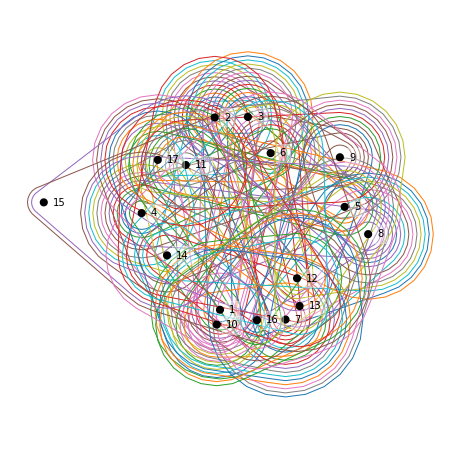

In [40]:
#hypergraph
He = hnx.Hypergraph(edges_e_MC)
hnx.draw(He, with_edge_labels=False)

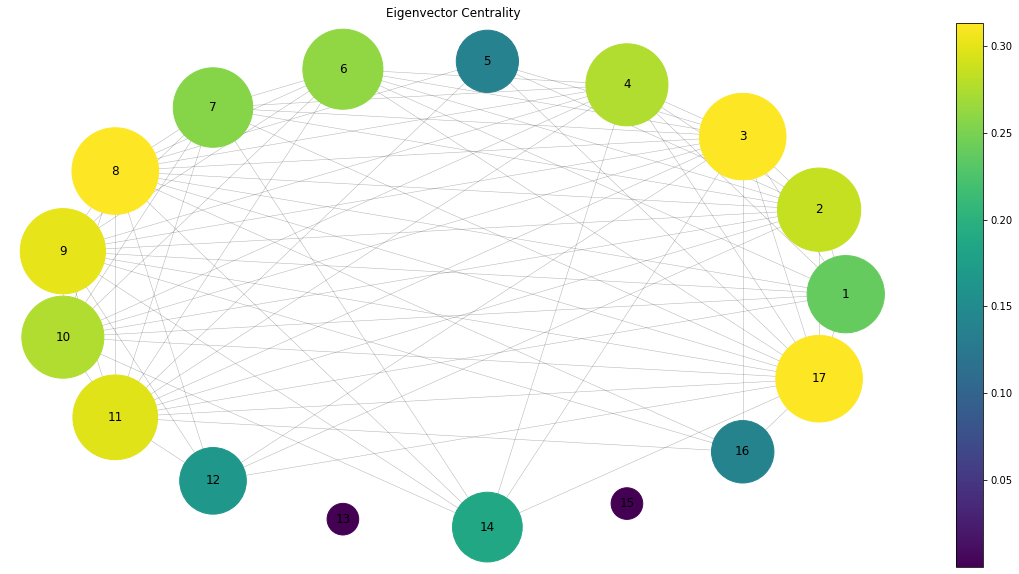

In [93]:
#graph with only 2-way dependencies
G = nx.Graph(Adj2_e_MC)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis,
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

In [43]:
from hypernetx.algorithms.s_centrality_measures import *

In [44]:
centr_E = s_betweenness_centrality(He, s=1, normalized=True)

In [45]:
centr_E

{1: 0.006601921470342523,
 2: 0.007331357117541329,
 3: 0.0064928023974076595,
 4: 0.00615235611123769,
 5: 0.007331357117541329,
 6: 0.007114503430292903,
 7: 0.006494621971595657,
 8: 0.007791013202197412,
 9: 0.007331357117541329,
 10: 0.00766604010025063,
 11: 0.00649758075744918,
 12: 0.004514680008101061,
 13: 0.006101103453077137,
 14: 0.0071985598465861625,
 15: 0.00766604010025063,
 16: 0.007395920356446673,
 17: 0.006595307713728769,
 18: 0.008079573934837095,
 19: 0.006315710361762993,
 20: 0.00766604010025063,
 21: 0.007111093706488444,
 22: 0.005313459688459689,
 23: 0.006717403575956208,
 24: 0.0084282834611782,
 25: 0.008221595655806182,
 26: 0.008123520607073238,
 27: 0.007353540100250627,
 28: 0.008666457811194654,
 29: 0.006829315299710036,
 30: 0.0066589240437924645,
 31: 0.00430948194106089,
 32: 0.008221595655806182,
 33: 0.005835682957393483,
 34: 0.007315954026480342,
 35: 0.007111093706488444,
 36: 0.0070130186577555004,
 37: 0.006267230576441102,
 38: 0.0074846

### Asia

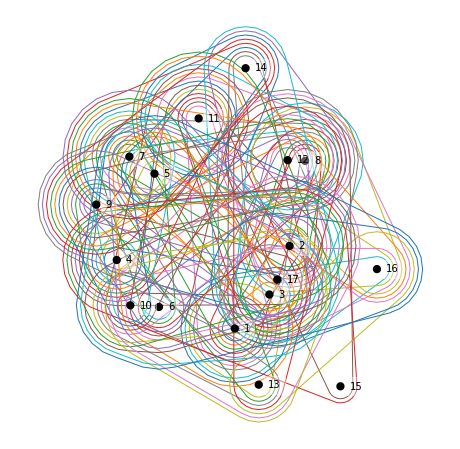

In [46]:
#hypergtraph
Has = hnx.Hypergraph(edges_as_MC)
hnx.draw(Has, with_edge_labels=False)

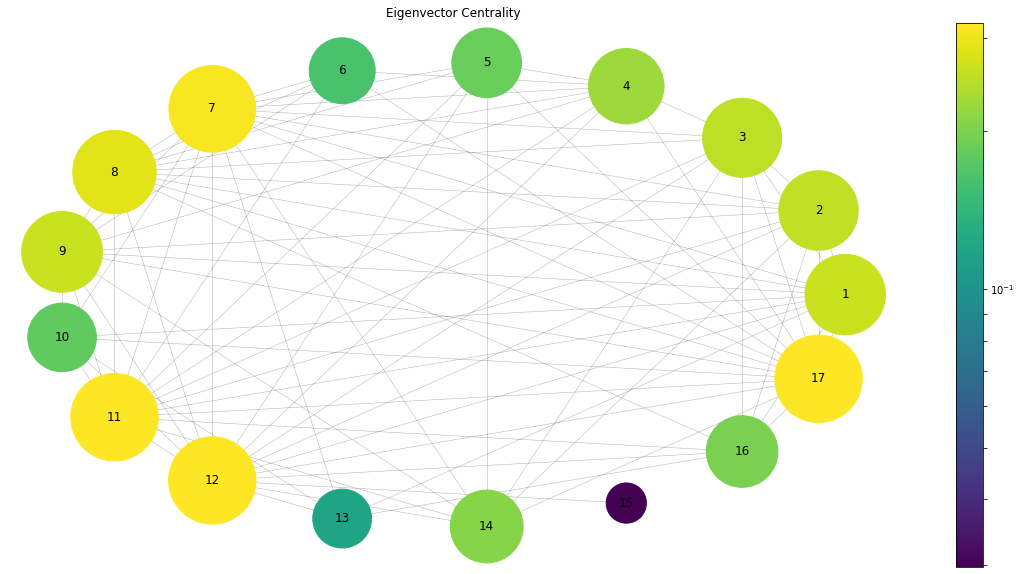

In [90]:
#graph with only 2-way dependencies
G = nx.Graph(Adj2_as_MC)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis,
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

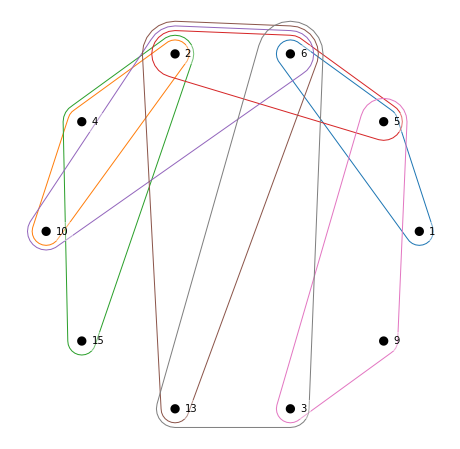

In [98]:
Has_restrict_edges3 = Has.restrict_to_edges(list(e for e in edges_as_MC if len(edges_as_MC[e])==3))
hnx.draw(Has_restrict_edges3, pos=nx.circular_layout(Has_restrict_edges3), with_edge_labels=False)

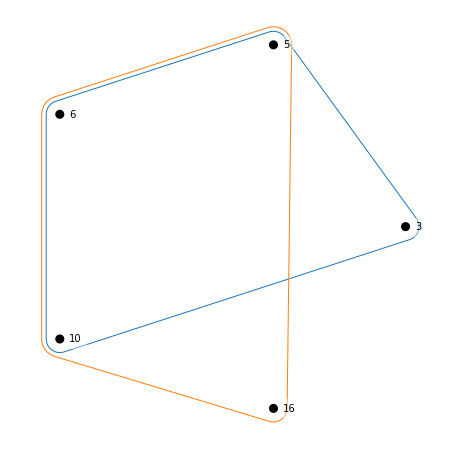

In [99]:
Has_restrict_edges4 = Has.restrict_to_edges(list(e for e in edges_as_MC if len(edges_as_MC[e])==4))
hnx.draw(Has_restrict_edges4, pos=nx.circular_layout(Has_restrict_edges4), with_edge_labels=False)

### Africa

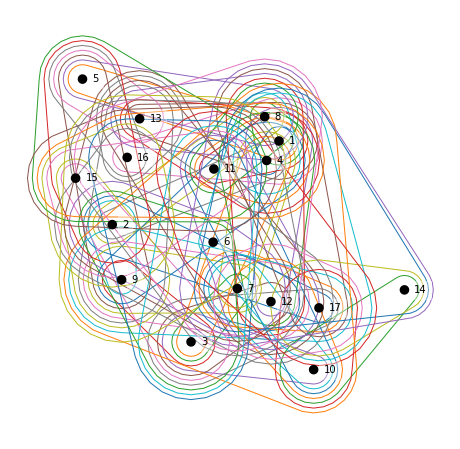

In [48]:
#hypergraph
Haf = hnx.Hypergraph(edges_af_MC)
hnx.draw(Haf, with_edge_labels=False)

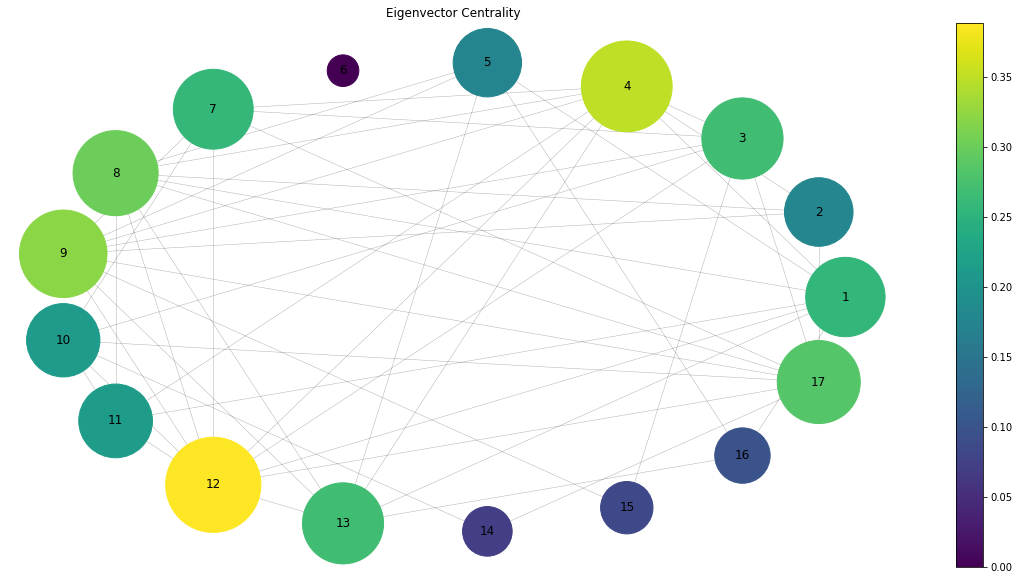

In [94]:
#graph with only 2-way dependencies
G = nx.Graph(Adj2_af_MC)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis,
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

### Americas

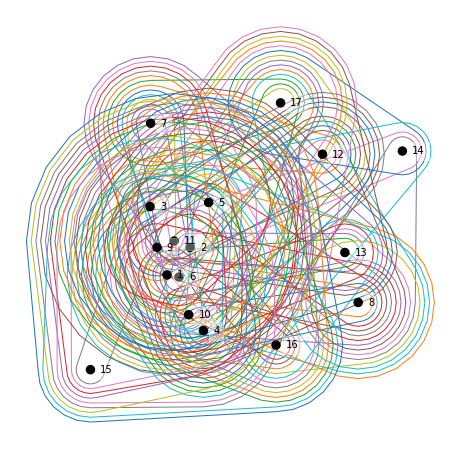

In [50]:
#hypergraph
Ham = hnx.Hypergraph(edges_am_MC)
hnx.draw(Ham, with_edge_labels=False)

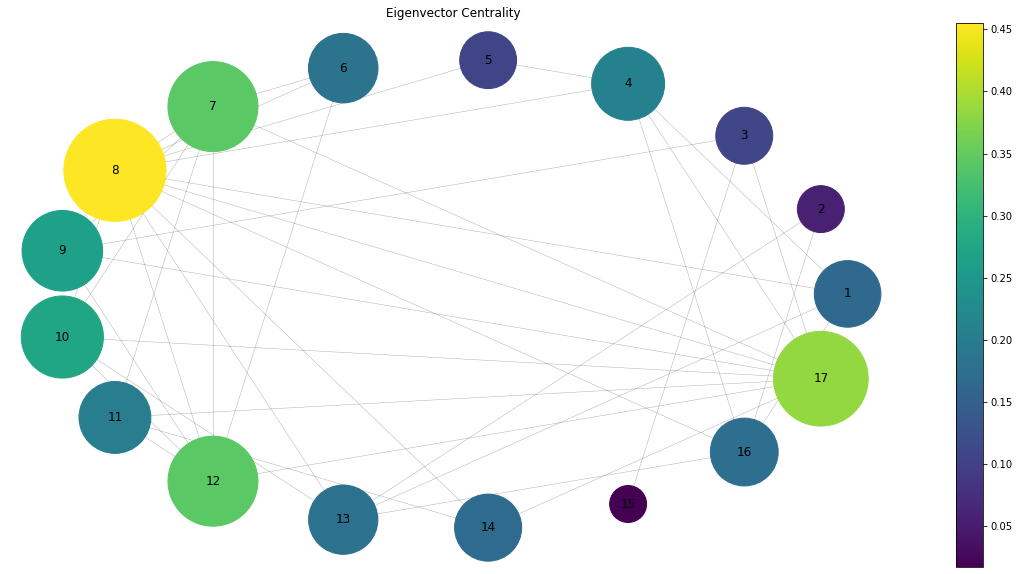

In [95]:
#graph with only 2-way dependencies
G = nx.Graph(Adj2_am_MC)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis,
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

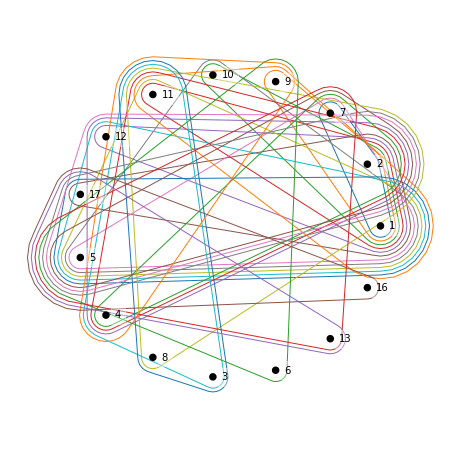

In [58]:
Ham_restrict_edges3 = Ham.restrict_to_edges(list(e for e in edges_am_MC if len(edges_am_MC[e])==3))
hnx.draw(Ham_restrict_edges3, pos=nx.circular_layout(Ham_restrict_edges3), with_edge_labels=False)

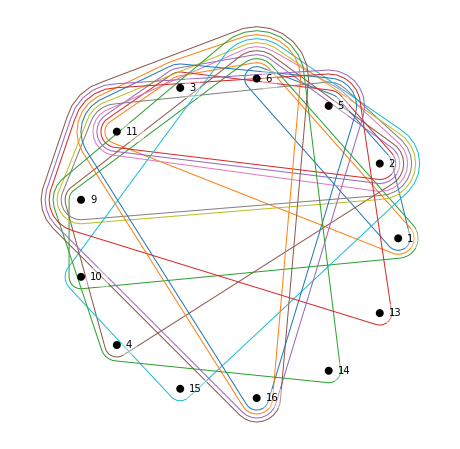

In [60]:
Ham_restrict_edges4 = Ham.restrict_to_edges(list(e for e in edges_am_MC if len(edges_am_MC[e])==4))
hnx.draw(Ham_restrict_edges4, pos=nx.circular_layout(Ham_restrict_edges4),with_edge_labels=False)

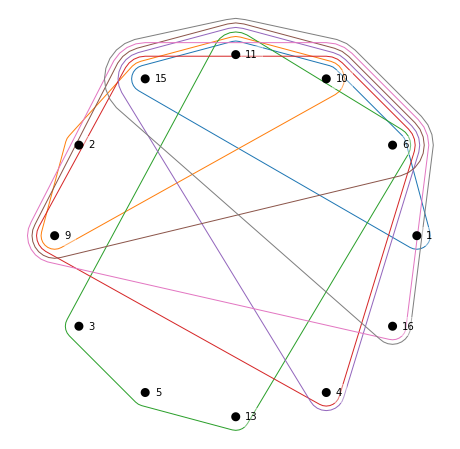

In [61]:
Ham_restrict_edges5 = Ham.restrict_to_edges(list(e for e in edges_am_MC if len(edges_am_MC[e])==5))
hnx.draw(Ham_restrict_edges5, pos=nx.circular_layout(Ham_restrict_edges5), with_edge_labels=False)

### Southern Asia

In [ ]:
#hypergraph
Hsas = hnx.Hypergraph(edges_sas_MC)
hnx.draw(Hsas, with_edge_labels=False)

In [ ]:
#graph with only 2-way dependencies
G = nx.Graph(Adj2_sas_MC)     #define graph
pos = nx.circular_layout(G)  # compute graph layout
degree = nx.eigenvector_centrality(G)     #compute degree centrality

plt.figure(figsize=(20, 10))   
plt.axis('off')
plt.title('Eigenvector Centrality')

#define nodes with color and size depending on degree
nodes = nx.draw_networkx_nodes(G, pos, node_size= list(12**4*i+1000 for i in degree.values()), cmap=plt.cm.viridis,
                       node_color=list(i for i in degree.values()), nodelist=list(degree.keys()))
#nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
labels=nx.draw_networkx_labels(G,pos, labels=n_labels)
#draw edges
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.3)
plt.colorbar(nodes)
plt.show(G)

In [ ]:
Hsas_restrict_edges3 = Hsas.restrict_to_edges(list(e for e in edges_sas_MC if len(edges_sas_MC[e])==3))
hnx.draw(Hsas_restrict_edges3, pos=nx.circular_layout(Hsas_restrict_edges3), with_edge_labels=False)

## Trying different visualisations of hypergraphs

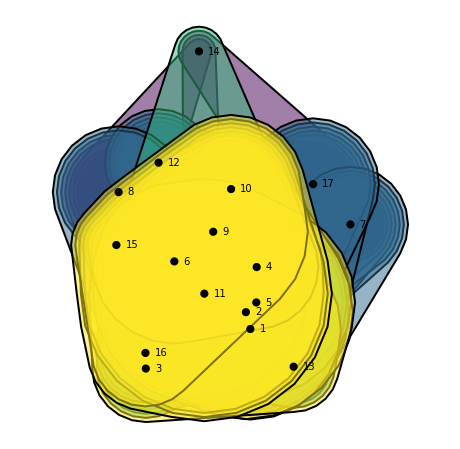

In [63]:
#Trying out different visualizations
cmap = plt.cm.viridis
alpha = .5

sizes = np.array([len(e) for e in Ham.edges()])
norm = plt.Normalize(sizes.min(), sizes.max())

hnx.drawing.draw(Ham,
                 label_alpha=0,
                 edges_kwargs={
                     'facecolors': cmap(norm(sizes))*(1, 1, 1, alpha),
                     'edgecolors': 'black',
                     'linewidths': 2
                 }, with_edge_labels=False)

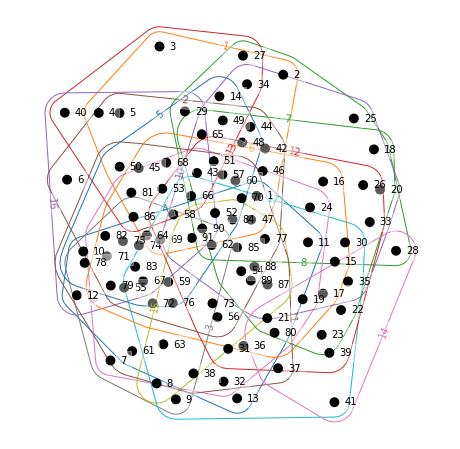

In [64]:
HD = Ham.dual()
hnx.draw(HD)

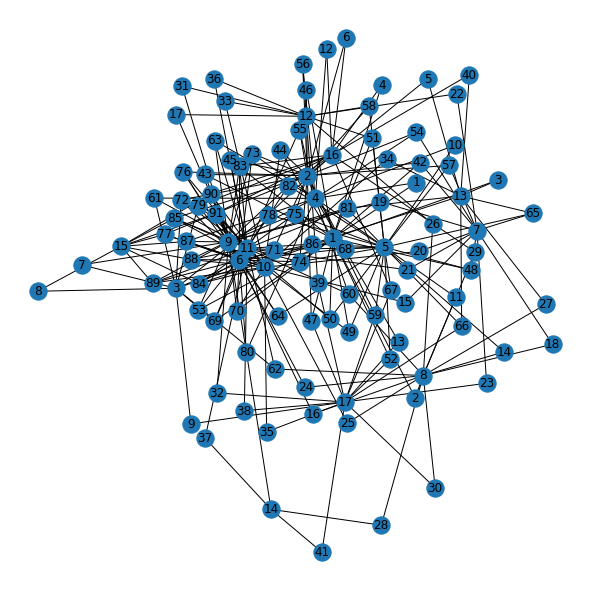

In [65]:
BH = Ham.bipartite()
nx.draw(BH, with_labels=True)

In [66]:
nodes_n = list(['{}'.format(i+1) for i in range(17)]) 
deg = nx.algorithms.bipartite.centrality.degree_centrality(BH, nodes=nodes_n) 

In [69]:
deg

{'4': 0.15384615384615385,
 '10': 0.17582417582417584,
 '7': 0.13186813186813187,
 '12': 0.1208791208791209,
 '15': 0.09890109890109891,
 '16': 0.13186813186813187,
 '13': 0.09890109890109891,
 '8': 0.15384615384615385,
 '5': 0.2417582417582418,
 '6': 0.2417582417582418,
 '14': 0.04395604395604396,
 '17': 0.15384615384615385,
 '3': 0.1208791208791209,
 '2': 0.26373626373626374,
 '9': 0.23076923076923078,
 '11': 0.3186813186813187,
 '1': 0.2197802197802198,
 1: 0.11764705882352941,
 2: 0.11764705882352941,
 3: 0.11764705882352941,
 4: 0.11764705882352941,
 5: 0.11764705882352941,
 6: 0.11764705882352941,
 7: 0.11764705882352941,
 8: 0.11764705882352941,
 9: 0.11764705882352941,
 10: 0.11764705882352941,
 11: 0.11764705882352941,
 12: 0.11764705882352941,
 13: 0.11764705882352941,
 14: 0.11764705882352941,
 15: 0.11764705882352941,
 16: 0.11764705882352941,
 17: 0.11764705882352941,
 18: 0.11764705882352941,
 19: 0.11764705882352941,
 20: 0.11764705882352941,
 21: 0.11764705882352941,
 2

In [70]:
M_ad = Ham.adjacency_matrix(s=1)
M_ad.toarray()

array([[ 0,  2,  1,  1,  1,  2,  0,  1,  1,  1,  4,  1,  1,  4,  4,  4,
         1],
       [ 2,  0,  0,  0,  2,  8,  0,  0,  0,  0,  7,  0,  1,  2,  4,  5,
         1],
       [ 1,  0,  0,  1,  0,  1,  1,  1,  1,  3,  1,  0,  0,  3,  1,  1,
         2],
       [ 1,  0,  1,  0,  0,  1,  0,  1,  1,  2,  1,  0,  0,  3,  1,  1,
         2],
       [ 1,  2,  0,  0,  0,  2,  1,  1,  1,  3,  4,  0,  2,  1,  3,  5,
         1],
       [ 2,  8,  1,  1,  2,  0,  1,  1,  1,  1,  8,  0,  0,  3,  5,  5,
         4],
       [ 0,  0,  1,  0,  1,  1,  0,  1,  1,  4,  1,  0,  1,  1,  1,  2,
         1],
       [ 1,  0,  1,  1,  1,  1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  2,
         1],
       [ 1,  0,  1,  1,  1,  1,  1,  1,  0,  4,  0,  1,  1,  2,  1,  1,
         2],
       [ 1,  0,  3,  2,  3,  1,  4,  1,  4,  0,  4,  0,  3,  7,  4,  8,
         6],
       [ 4,  7,  1,  1,  4,  8,  1,  1,  0,  4,  0,  1,  4,  6,  9, 11,
         4],
       [ 1,  0,  0,  0,  0,  0,  0,  1,  1,  0,  1,  0,  0,  0,  

In [71]:
M_ad.toarray().shape

(17, 17)

In [83]:
Ham.degree('17', s=1)

14

In [75]:
Ham.degree('17', s=2)

14

In [76]:
Ham.degree('17', s=3)

5

In [77]:
Ham.degree('17', s=4)

0

In [78]:
Ham.degree('15', s=2)

9

In [79]:
Ham.degree('15', s=3)

8

In [80]:
Ham.degree('15', s=4)

8

In [81]:
degrees_2 = {}
for i in range(17):
    node = '{}'.format(i+1)
    degrees_2[node]= Ham.degree(node, s=2)
degrees_2

{'1': 20,
 '2': 24,
 '3': 11,
 '4': 14,
 '5': 22,
 '6': 22,
 '7': 12,
 '8': 14,
 '9': 21,
 '10': 16,
 '11': 29,
 '12': 11,
 '13': 9,
 '14': 4,
 '15': 9,
 '16': 12,
 '17': 14}

In [82]:
degrees_3 = {}
for i in range(17):
    node = '{}'.format(i+1)
    degrees_3[node]= Ham.degree(node, s=3)
degrees_3

{'1': 16,
 '2': 22,
 '3': 8,
 '4': 9,
 '5': 20,
 '6': 19,
 '7': 5,
 '8': 2,
 '9': 16,
 '10': 11,
 '11': 25,
 '12': 4,
 '13': 4,
 '14': 1,
 '15': 8,
 '16': 7,
 '17': 5}

In [73]:
# As with any iterator you can get all of the values in a list
list(Ham.neighbors('6'))

['10',
 '7',
 '16',
 '8',
 '3',
 '2',
 '9',
 '11',
 '4',
 '15',
 '12',
 '13',
 '14',
 '5',
 '1']

## Experiments on Target level

In [84]:
edges_e_t_MC, Adj2_e_t_MC = dHSIC_links_MC('Europe', continents_prep_t, targets, stop_after_2=True)

combinations:  2
number of combinations available:  2850
Edges found with  2 nodes:  1004


In [85]:
edges_af_t_MC, Adj2_af_t_MC = dHSIC_links_MC('Africa', continents_prep_t, targets, stop_after_2=True)

combinations:  2
number of combinations available:  2850
Edges found with  2 nodes:  449


In [86]:
edges_as_t_MC, Adj2_as_t_MC = dHSIC_links_MC('Asia', continents_prep_t, targets, stop_after_2=True)

combinations:  2
number of combinations available:  2850
Edges found with  2 nodes:  696


In [87]:
edges_am_t_MC, Adj2_am_t_MC = dHSIC_links_MC('Americas', continents_prep_t, targets, stop_after_2=True)

combinations:  2
number of combinations available:  2850
Edges found with  2 nodes:  451
